In [ ]:
import torch
from torch import tensor
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from ast import literal_eval
from py_experimenter.experimenter import PyExperimenter
import torch
import mysql.connector
import openml


from py_experimenter.database_connector_mysql import DatabaseConnectorMYSQL

# def connect(self):

#     db = mysql.connector.connect(
#         host="xxx",
#         user="xxx",
#         password="xxx",
#         database="xxx",
#         ssl_disabled=False,
#     )
#     return db


# def _start_transaction(self, connection, readonly=False):
#     if not readonly:
#         connection.start_transaction()


# DatabaseConnectorMYSQL.connect = connect
# DatabaseConnectorMYSQL._start_transaction = _start_transaction

%matplotlib inline

In [2]:
experimenter = PyExperimenter(
    experiment_configuration_file_path="./experiments/config/cfg_simple_debug.yml",
)
exp_frame = experimenter.get_table()
# exp_frame = exp_frame[exp_frame.fraction_cal_samples >= 0.19999]
# exp_frame = exp_frame[exp_frame.openml_id != 4534]
# exp_frame = exp_frame[exp_frame.openml_id != 15]
exp_frame = exp_frame[exp_frame.openml_id != 41]
exp_frame = exp_frame[exp_frame.openml_id != 182]
exp_frame = exp_frame[exp_frame.openml_id != 182]
exp_frame = exp_frame[exp_frame.openml_id != 11]
exp_frame = exp_frame[exp_frame.openml_id != 307]
exp_frame = exp_frame[exp_frame.master_seed.isin(list(range(0,15)))]
# exp_frame = exp_frame[exp_frame. != 41]
# exp_frame = exp_frame[exp_frame.openml_id != 31]


2025-05-22 14:00:38,076  | py-experimenter - INFO     | Found 4 keyfields
2025-05-22 14:00:38,089  | py-experimenter - INFO     | Found 2 resultfields
2025-05-22 14:00:38,093  | py-experimenter - INFO     | Found 1 logtables
2025-05-22 14:00:38,095  | py-experimenter - INFO     | Found logtable cp_rank_dev__new_cross__results
2025-05-22 14:00:38,097  | py-experimenter - WARNING  | No custom section defined in config
2025-05-22 14:00:38,101  | py-experimenter - WARNING  | No codecarbon section defined in config
2025-05-22 14:00:38,103  | py-experimenter - INFO     | Initialized and connected to database


In [3]:
import numpy as np
datasets = {}
num_classes = {}
dataset_renamer = {}
for id in exp_frame.openml_id.unique():
    dataset = openml.datasets.get_dataset(id.item())
    target_attribute = dataset.default_target_attribute
    X, y, _, _ = dataset.get_data(target=target_attribute)
    datasets[id] = dataset
    dataset_renamer[id] = dataset.name
    num_classes[id] = len(np.unique(y))

In [4]:
logtable = experimenter.get_logtable("results")
result_df = pd.merge(exp_frame, logtable, left_on="ID", right_on="experiment_id")

In [5]:
result_df = result_df[result_df.conformity_score.isin(["rand_aps","aps", "thr", "ranker_vanilla"])] 

In [6]:
result_df.coverage_rate = result_df.coverage_rate.astype(float)

In [7]:
result_df.columns


Index(['ID_x', 'model', 'openml_id', 'master_seed', 'fraction_cal_samples',
       'creation_date', 'status', 'start_date', 'name', 'machine',
       'clf_seed_x', 'mccv_seed_x', 'end_date', 'error', 'ID_y',
       'experiment_id', 'timestamp', 'coverage_rate', 'average_size',
       'cov_gap', 'vio_classes', 'sscv', 'wsc', 'acc', 'bacc',
       'conformity_score', 'alpha', 'gradient_updates', 'clf_seed_y',
       'mccv_seed_y', 'len_train', 'len_test', 'len_cal'],
      dtype='object')

In [8]:
df = result_df

result_df["dataset"] =  result_df["openml_id"].replace(dataset_renamer)
result_df["num_classes"] = result_df["openml_id"].replace(num_classes)

result_df["dataset"] = r"$\texttt{" + result_df["dataset"] + "}$"
result_df["dataset"] = result_df["dataset"] + " (" + result_df["num_classes"].astype(str) + ")"

cs_renamer = {"aps":"APS",
              "rand_aps": "APS (rand)",
              "thr": "LAC",
              "ranker_vanilla": " "}


model_renamer = {"ranker":"Ranker",
              "classifier": "Classifier"}


result_df["conformity_score"] =  result_df["conformity_score"].replace(cs_renamer)
result_df["model"] =  result_df["model"].replace(model_renamer)

result_df["method"] = result_df["model"] + " " + result_df["conformity_score"]
# result_df = result_df.sort_values(by="num_classes", ascending=True)
# group_cols = ['dataset', 'alpha', 'fraction_cal_samples', 'model']
group_cols = ['dataset', 'alpha', 'method']
metrics_max = ['acc','coverage_rate']
metrics_min = ['average_size']
metrics = metrics_max + metrics_min
result_df = result_df[result_df.alpha.isin([0.02,0.05,0.1, 0.2])]
result_df1 = result_df[result_df.openml_id.isin([4534, 31,15,187])]
result_df2 = result_df[result_df.openml_id.isin([61,54,35])]
grouped_df1 = result_df1.groupby(group_cols).agg({metric: ['mean', 'std'] for metric in metrics}).reset_index()
grouped_df2 = result_df2.groupby(group_cols).agg({metric: ['mean', 'std'] for metric in metrics}).reset_index()

grouped_df1.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in grouped_df1.columns]
grouped_df2.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in grouped_df2.columns]

# grouped_df = grouped_df.sort_values(by='num_classes', ascending=True)
agg_dict = {f"{metric}_mean": 'max' for metric in metrics_max}
agg_dict.update({f"{metric}_mean": 'min' for metric in metrics_min})
best_values1 = grouped_df1.groupby(['dataset', 'alpha']).agg(agg_dict).reset_index()
best_values2 = grouped_df2.groupby(['dataset', 'alpha']).agg(agg_dict).reset_index()
# group_cols = ['dataset', 'alpha', 'method']
# grouped_df = grouped_df.drop(["num_classes"], axis=1)

In [16]:
def generate_latex_table_with_lines(df, group_cols, value_cols, best_values):
    """Generate a LaTeX table with multirow entries, bold the best values, and add lines between consecutive multirows."""
    
    def format_value(group, metric, max=True):
        """Format the value, making the highest value bold."""
        
        value_mean = group[f"{metric}_mean"]
        value_std = group[f"{metric}_std"]
        max_value = best_values.loc[
            (best_values['dataset'] == group['dataset']) & 
            (best_values['alpha'] == group['alpha']), f"{metric}_mean"].values[0]
            # (best_values['fraction_cal_samples'] == group['fraction_cal_samples']), metric].values[0]
        if value_mean == max_value:
            return f"$\\mathbf{{{value_mean:.3f} \\pm {value_std:.3f}}}$"
        else:
            return f"${value_mean:.3f} \\pm {value_std:.3f}$"
    
    def recursive_build(df, group_cols):
        # if len(group_cols) == 1:
            # Base case: only one group left, print it directly
            latex_str = ""
            prev_row = None
            for row_id, row in df.iterrows():
                latex_str_tmp = ""
                col_id_list = []
                for col_id, col in enumerate(group_cols):
                    if prev_row is None or row[col] != prev_row[col]:
                        col_id_list.append(col_id)
                        filter_cols = group_cols[:col_id+1]
                        indices = []
                        values = []
                        for fcol in filter_cols:
                            indices.append(fcol)
                            values.append(row[fcol])
                        criteria = dict(zip(indices, values))
                        # Filter the DataFrame using query
                        mask = pd.Series([True] * len(df))

                        # Iterate over criteria to apply conditions
                        for key, value in criteria.items():
                            mask = mask & (df[key] == value)

                        # Filter the DataFrame
                        filtered_df = df[mask]

                        length = len(filtered_df)

                        latex_str_tmp += f" \\multirow{{{length}}}{{*}}{{{row[col]}}} & "
                        if col_id == len(group_cols) - 1:
                            latex_str_tmp += " & ".join([format_value(row, col) for col in value_cols]) + " \\\\\n"

                        # if prev_row is not None and col_id < len(group_cols) - 1:
                        # latex_str_tmp += " \\\\ \cline{%d-%d} \\\\" % (col_id + 1, len(group_cols) + len(value_cols))

                    else:
                        latex_str_tmp += " & "
                        if col_id == len(group_cols) - 1:
                            latex_str_tmp += " & ".join([format_value(row, col) for col in value_cols]) + " \\\\\n"
                if row_id > 0 and group_cols[min(col_id_list)] != "model":
                    latex_str += "\\cline{%d-%d}" % (min(col_id_list)+1, len(group_cols) + len(value_cols))
                latex_str += latex_str_tmp
                indices = []
                values = []
                prev_row = row
            return latex_str
        
    # Start recursive building                                                  
    latex_body = recursive_build(df, group_cols)

    # Complete LaTeX table
    num_columns = len(group_cols) + len(value_cols)
    col_format = 'l' * len(group_cols) + 'r' * len(value_cols)
    latex_table = f"""
\\begin{{tabular}}{{{col_format}}}
\\toprule
{' & '.join(group_cols)} & {' & '.join(value_cols)} \\\\
\\midrule
{latex_body}
\\bottomrule
\\end{{tabular}}
"""
    return latex_table

# Generate the LaTeX table with bold formatting and lines

latex_table = generate_latex_table_with_lines(grouped_df1, group_cols, metrics, best_values1)

# Print or save the LaTeX table
with open('out_table.tex', 'w') as f:
    print(latex_table.replace("_", "\_"), file=f)


In [10]:
# result_df = result_df[result_df.method != "Classifier APS"]

In [11]:
result_df.alpha.unique()


array([0.02, 0.05, 0.1 , 0.2 ])

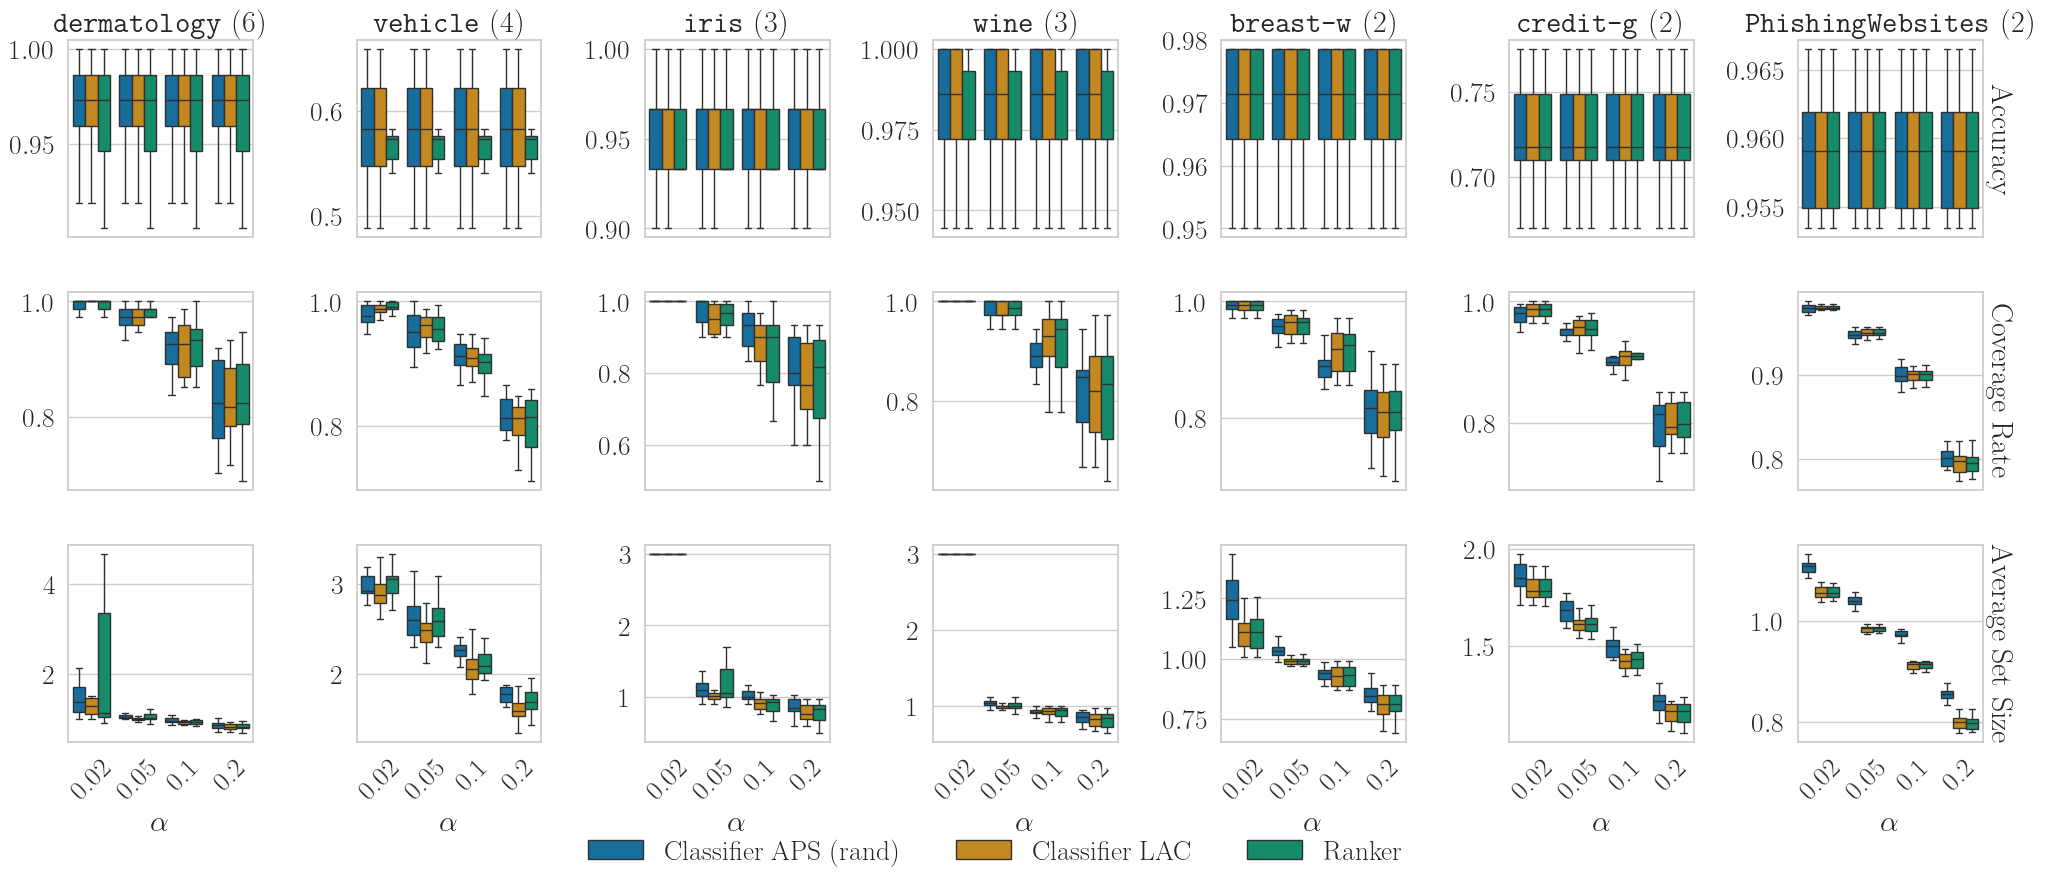

In [12]:
from matplotlib.colors import Colormap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set(font_scale=1.8,rc={'text.usetex' : True})
sns.set_style("whitegrid")
sns.set_palette("colorblind")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (10, 6)

# Define columns
group_cols = ['dataset', 'alpha', 'method']
metrics_max = ['acc', 'coverage_rate']
metrics_min = ['average_size']
metrics = metrics_max + metrics_min

result_df = result_df[result_df.method != "Classifier APS"] 
alpha_df = result_df[result_df.alpha.isin([0.02,0.05,0.1, 0.2])]


# Melt the original result_df to long format for seaborn
melted_df = alpha_df.melt(id_vars=group_cols, value_vars=metrics, var_name='metric', value_name='value')
melted_df.replace({"metric": {"acc": "Accuracy", "coverage_rate": "Coverage Rate", "average_size": "Average Set Size"}}, inplace=True)


# Create FacetGrid with a row per metric
g = sns.FacetGrid(
    melted_df, col="dataset", row="metric", margin_titles=True, 
    despine=False, sharey=False, #height=4, aspect=2.4
)

g.set_titles(col_template="{col_name}", row_template="{row_name}")

# Map boxplots with hue for method separation
g.map_dataframe(sns.boxplot, x="alpha", y="value", hue="method", dodge=True, showfliers=False, palette="colorblind")
g.set_axis_labels(r"$\alpha$", " ")
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# # Add a legend outside the plot
# g.add_legend(title="Method", ncols=4)
# g._legend.set_bbox_to_anchor((0.5, -0.05))
handles, labels = g.axes[0, 0].get_legend_handles_labels()
g.fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.07), frameon=False)
# 
#   # Move legend under plot
# g._legend.set_frame_on(False)  # Remove legend frame
# g._legend.set_title("Method")  # Set title
plt.subplots_adjust(bottom=0.15)
plt.savefig("boxplots.pdf", bbox_inches='tight')

In [13]:
result_df

,ID_x,model,openml_id,master_seed,fraction_cal_samples,creation_date,status,start_date,name,machine,...,alpha,gradient_updates,clf_seed_y,mccv_seed_y,len_train,len_test,len_cal,dataset,num_classes,method
4,1,Classifier,35,1,0.25,2025-02-11 00:13:14,done,2025-02-11 00:13:34,PyExperimenter,DESKTOP-H1LJPT0,...,0.02,1800,1095513148,3280387012,219,74,73,$\texttt{dermatology}$ (6),6,Classifier APS (rand)
5,1,Classifier,35,1,0.25,2025-02-11 00:13:14,done,2025-02-11 00:13:34,PyExperimenter,DESKTOP-H1LJPT0,...,0.05,1800,1095513148,3280387012,219,74,73,$\texttt{dermatology}$ (6),6,Classifier APS (rand)
6,1,Classifier,35,1,0.25,2025-02-11 00:13:14,done,2025-02-11 00:13:34,PyExperimenter,DESKTOP-H1LJPT0,...,0.10,1800,1095513148,3280387012,219,74,73,$\texttt{dermatology}$ (6),6,Classifier APS (rand)
7,1,Classifier,35,1,0.25,2025-02-11 00:13:14,done,2025-02-11 00:13:34,PyExperimenter,DESKTOP-H1LJPT0,...,0.20,1800,1095513148,3280387012,219,74,73,$\texttt{dermatology}$ (6),6,Classifier APS (rand)
20,1,Classifier,35,1,0.25,2025-02-11 00:13:14,done,2025-02-11 00:13:34,PyExperimenter,DESKTOP-H1LJPT0,...,0.02,1800,1095513148,3280387012,219,74,73,$\texttt{dermatology}$ (6),6,Classifier LAC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7799,276,Ranker,31,14,0.25,2025-02-11 00:13:14,done,2025-02-11 06:02:18,PyExperimenter,DESKTOP-H1LJPT0,...,0.20,4500,1098547461,4038782778,600,200,200,$\texttt{credit-g}$ (2),2,Ranker
7820,277,Ranker,4534,14,0.25,2025-02-11 00:13:14,done,2025-02-11 06:02:23,PyExperimenter,DESKTOP-H1LJPT0,...,0.02,49800,1098547461,4038782778,6633,2211,2211,$\texttt{PhishingWebsites}$ (2),2,Ranker
7821,277,Ranker,4534,14,0.25,2025-02-11 00:13:14,done,2025-02-11 06:02:23,PyExperimenter,DESKTOP-H1LJPT0,...,0.05,49800,1098547461,4038782778,6633,2211,2211,$\texttt{PhishingWebsites}$ (2),2,Ranker
7822,277,Ranker,4534,14,0.25,2025-02-11 00:13:14,done,2025-02-11 06:02:23,PyExperimenter,DESKTOP-H1LJPT0,...,0.10,49800,1098547461,4038782778,6633,2211,2211,$\texttt{PhishingWebsites}$ (2),2,Ranker


In [14]:
grouped_df

NameError: name 'grouped_df' is not defined